In [1]:
#hide
from fastbook import *

# Other computer vision problems

In the previous chapters we learnt about some of the basics of deep learning and some important 
methods to improve the models such as selecting learning rate and no of epochs which are very 
important.Next we would be studying about multilabel classification and regression in this chapter.
Multilabel classification is when we predict more than one labels for an image and in second our 
dependent variable is a continuous number instead of a category.

Likewise in this chapter we would study in deep about topics such as activations,targets and loss
functions in deep learning.

## Multi-Label Classification

Till now we built many Image Classifiers but in all of them we were predicting one label for one image
.But Images cannot always have single label.There are several images in real world which contain more 
than one objects or sometimes no objects also.

This is actually a problem with most of the image classfiers which we built that even if the image 
doesn't contain any of the objects in the classes still the model will predict either of the classes 
with some probability.This is what happens when we build a Bear Classifier.If the image doesn't have 
any kind of bear even then model will predict it to be a grizzly,black or teddy bear.There should be 
an option where it is predicted that there is "no bear at all".

Multilabel Image Classifiers are not much in use even though they can be helpful.Though they are not 
in much of practice still multilabel classifiers would be more applicable than the single ones.

Before building the model let's see how the data for a multilabelled images look like and how can we
convert it into a form so that it can be trained.

### The Data

For building multilabelled Image classifier in this chapter we will be using the PASCAL dataset.It
contains Images which are classified into one or more objects.We proceed by first downloading and 
extracting the dataset.

In [3]:
#Downloading and extracting the data using untar_data
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
#Setting the path for the dataset
Path.BASE_PATH=path

Next we see the contents of the directory using the ls method that how the data is arranged in 
different folders

In [5]:
#See the contents of the folder 
path.ls()

(#8) [Path('segmentation'),Path('test'),Path('test.csv'),Path('test.json'),Path('train'),Path('train.csv'),Path('train.json'),Path('valid.json')]

Now the dataset contains many folders and files for train and test data.The csv file tells us about 
the labels and that if the image is included in training or validation set using different columns in 
the dataset.Let's explore the csv file using the pandas library in python.It is mainly used for 
handling such tabular data.Manipulating the data,arranging it,data cleaning,data encoding everything
can be done using pandas library in Python.

We use read_csv function in the pandas to open the csv file.

In [6]:
#Reading dataframe using the read_csv function from pandas library in python
df = pd.read_csv(path/'train.csv')
df.head()#displaying the first 5 entries in the dataset using the head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


The above data is stored in a dataframe as pandas read the file using read_csv.The data has three 
columns, fname which is file name ,the labels and an another columns "is_valid" which is a binary
boolean feature which is True if the data is in validation set and false if it belongs to training set
.

Let's learn about pandas library and how it can be used to manipulate and analyze the tabular and time
series data.

### Sidebar: Pandas and DataFrames

Pandas is a very useful and special Python Library.It is used to handle large tabular data and one of
the main objects in which the data is stored is dataframe.DataFrame is simply a table containing rows
and columns.Pandas have many functions which can read the dataframes from raw data.In the previous
section we used read_csv function from pandas to store an unknown piece of data.Therefore data can be 
obtained from a csv file,from dictionary,database and many more.

In the previous section we had already stored the dataset in a DataFrame.We can access the rows and
columns of the table using  using some indexing.

We display the first column of the dataset containing the names of the images using the iloc property.

In [11]:
#accessing first column of the dataframe
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

While accessing any dataframe through iloc property the first index represents row and the next index
represents column.Only rows can also be accessed using df.iloc[a].

In [12]:
#Accessing rows and columns using iloc property
df.iloc[0,:]#Accessing first row and all columns
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0] #Accessing first row 

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

A single column name can be accessed by indexing the column name with dataframe directly 

In [13]:
#accessing column "fname" by indexing with dataframe
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

New dataframe can be created using dictionary where keys are columns and values are rows.Pandas
DataFrame function is used.

In [14]:
#Create dataframe using dictionary key-value pairs
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


Calculations can be done on columns and new columns can be created by operations on two columns.

In [15]:
#Create new column by adding two columns
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


Pandas is a very flexible library and is very important to know for a Data Scientist as it is widely
used for data manipulation and data analysis.Other libraries such as matplotlib and numpy are also one
of the important libraries for data visualization and mathematical and scientific computations.

### End sidebar

We have seen how the data is arranged and how the contents of the data.Now to train our model we 
should get the data in a DataLoaders object.We can use DataBlock API for creating DataLoaders object.
Let's see how do we create the dataloaders object and also learn more about datasets and dataframes..

### Constructing a DataBlock

Currently we have a pandas DataFrame and we have to convert it into DataLoaders object.Till now most 
of the times when we trained our model the data was arranged in folders and not as csv file.So the 
process will be little different but we will be using DataBlock API to get the Dataloaders object for
this data.

PyTorch and fastai both have mainly two objects for splitting the dataset and accessing the training 
and validation set separately:-
    
1.Dataset:-It returns tuples of dependent and independent variable pairs
    
2.DataLoader:-It splits the data into mini-batches such that it is iterable and each mini-batch has
tuples of dependent and independent variable pairs.
These objects are provided by PyTorch.

Fastai which is built on top of this provides two classes for accessing training and validation sets.

1.Datasets:-This contains a training Dataset and a validation Dataset.

2.DataLoaders:-This contains a training DataLoader and a validation DataLoader.
    
A dataloader is built on top of Dataset.Therefore,it is better to create Datasets first and then 
convert it into DataLoaders.

While building DataBlock gradually step by step do multiple tasks together.
Let's learn accessing validation sets and training sets using the dataloaders and Datasets.To show
examples here we won't be using the PASCAL dataset instead we would be using the dataset of alphabets
where alphabets and their index are dependent and independent variables respectively.

In [16]:
#Dataset u get a tuple for a dependent and indepenedent variable
a=list(enumerate(string.ascii_lowercase))
a[0],len(a)

((0, 'a'), 26)

Now we have the alphabets dataset in a.Let's load the data in Dataloader with the batch size of 8.
When we load the data into DataLoader we get dependent and independent variables in different tuples

In [17]:
#Creating a dataloader with the alphabet
dl_a=DataLoader(a,batch_size=8,shuffle=True)
b=first(dl_a)#get the first batch from dl_a
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

We can segregate the elements in these tuples according to the dependent and independent variables 
pairs in separate tuples like (a,1),(b,2) like this using the zip function through which we pass b[0]
and b[1] which are the big tuples in the DataLoader object.

In [18]:
#Segregating the Dataloader items into different pairs(y,x) in tuples 
list(zip(b[0],b[1]))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [19]:
#transposing
list(zip(*b))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

Let's learn about the Datasets object now.We pass the same alphabets data through the Datasets.
Previously when we had passed it through Dataloader we also passed the index.Here we are passing only
alphabets.So when we pass the data through Datasets we get a list of different tuples containing the
alphabets in order.So datasets converts it into list of tuples.

In [20]:
#Passing the alphabet data through the Datasets
a=list(string.ascii_lowercase)
dss=Datasets(a)
dss
#List of tuples obtained

(#26) [('a',),('b',),('c',),('d',),('e',),('f',),('g',),('h',),('i',),('j',)...]

We know that for data cleaning or making the data suitable for training we do some transformations on
all types of data specially in text data.So Datasets allow us to apply these transformations on the 
alphabet data.Let's see how this is done.We create two simple functions which take a string as input 
and simplyreturn a concatenated string with a letter.

In [21]:
#Functions for transformation
def f1(o):
    return(o+"a")#returns concatenated string 
def f2(o):
    return(o+"b")

We  created two functions f1 and df2 which do string concatenation.Let's see how to apply these 
through DataSets.f1 adds "__a__" and f2 adds "__b__" to the passed string.We pass the alphabets and 
the function "f1" and the alphabet list through the Datasets and it returns the transformed elements 
but in the form of tuples which can be indexed

In [22]:
#one function transformation passing function and alphabet list through the datasets
dss=Datasets(a,[[f1]])
dss[0] #tuple returned

('aa',)

Next we pass 2 functions together in the form of list of functions.So the alphabets are transformed 
such that both the functions are applied together on all the elements so we get a single tuple with 
the transformed element for each element in the list of alphabets.

In [23]:
#two functions transformation/two functions passed as a list
dss=Datasets(a,[[f1,f2]])
dss[0]#returns the transformed alphabet with both the functions applied together

('aab',)

Next we pass both the functions separately through the Datasets and not as a list so it returns two
transformed elements for each alphabet in the list as both the functions are applied separately on the
elements.

In [24]:
#pass separately through both functions
dss=Datasets(a,[[f1],[f2]])
dss[0] #returns two transformed elements for each alphabet.f1 ans f2 both applied separately.

('aa', 'ab')

After applying the transformation and getting the Datasets we can get Dataloaders from the datasets 
using the from_dsets method through which we pass the datasets and the batchsize which is 4 in the 
below example.

In [25]:
#Creating dataloaders from the datasets using the from_dsets method.
dls=DataLoaders.from_dsets(dss,batch_size=4,num_workers=0)#Pass the dataset and the batch size.

We can access the training and validation set using the dataloaders as dataloaders split the data into
both.

In [26]:
#first batch in training set
first(dls.train)

(('ra', 'sa', 'ka', 'wa'), ('rb', 'sb', 'kb', 'wb'))

We have learnt about creating the Dataloaders object and the datasets and how we access the training
and validation sets using the alphabets datasets example.Now we can continue with our previous dataset
of the Images data in csv file which we had loaded into a Dataframe.We discussed first that it is easy
to first convert the data into Datasets and then define the DataBlock API and then create dataloaders
from it..

We first create an empty DataBlock object which can be used later.Then we convert it into datasets by
passing the dataframe.

In [27]:
#Creating a datablock object
dblock = DataBlock()

In [28]:
#Creating datasets from Datablock object using Dataframe
dsets = dblock.datasets(df) #random split into training and validation with 20% validation

Now as we have converted the DataBlock into datasets the training and validation set can be accessed
separately using train and valid attribute.Let's check their lengths:

In [29]:
#Lengths of training and validation sets
len(dsets.train),len(dsets.valid)

(4009, 1002)

Let's get the dependent(y) and independent variable(x) in the first element of dataset as it is a 
tuple so we can get different x and y.

In [30]:
#getting x and y for the training set
x,y = dsets.train[0]
x,y #by default splits into 2 variables dependent and independent
#the exact variables can be accessed using column names

(fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object,
 fname         002786.jpg
 labels      horse person
 is_valid            True
 Name: 1401, dtype: object)

This returns one row in the dataframe but written twice.It is because datablock assumes two variables
,input and output.But we haven't yet mentioned which are those so it assumes the whole row as both 
input and target.There are two sets of variables in this now:the input(x) and the output(y).We need to
grab the suitable input and output fields using the get_x and get_y functions in the datablock.

In this data,the input is the file name("fname") and the output is the label column("label").We can 
thus create a DataBlock with the get_x and get_y functions.

In [31]:
x['fname']

'002786.jpg'

In [32]:
#get_x and get_y for dependent and independent variables
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])#Creating a DataBlock
dsets = dblock.datasets(df)#creating datasets from datablock
dsets.train[0]

('007204.jpg', 'cat')

So now we have tuples containing pairs of file names and labels.To get the filenames and labels in the
above code cell we used lambda function.It is just a simple way of defining the same.The same thing
can be defined using the following varbose approach.

In [33]:
#defining get_x and get_y using the normal function approach
def get_x(r): 
    return r['fname']
def get_y(r): 
    return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)#creating DataBlock using the same
dsets = dblock.datasets(df)#creating datasets
dsets.train[0]
#To open image path is needed

('002848.jpg', 'motorbike')

We can see that both methods of defining the get_x and get_y produce the same output.But lambda 
functions are good for quick iteration and not for serialization.So verbose approach is followed for 
exporting learner after training the model.

Till now we were not using the path to the image instead we were just taking a particular column of 
the dataframe.To open the image,we need to convert the independent variable into full path and since
some of the images are multilabelled so the dependent variable has to be split on the space character
so that there is a list of labels in the output at last.

In [34]:
#Using path to get the image and splitting the labels
def get_x(r): return path/'train'/r['fname']#get complete path for the image
def get_y(r): return r['labels'].split(' ')#splitting the labels using the Python("split") function
dblock = DataBlock(get_x = get_x, get_y = get_y)#creating the datablock
dsets = dblock.datasets(df)#datasets
dsets.train[0]

(Path('train/004010.jpg'), ['sofa', 'person'])

Now in the input we have the path to the actual image and the in the output we have the list of labels
for the image.Next we create a final datablock for the Image recognition.To open the image and convert
it into tensors,we have to do a set of transforms on the image.Block types whih we mention as input 
and output for the image let us do those transforms.The Image Block is the input but we can't use 
categoryblock as the output because this returns a single integer or label and we have our images as 
multilabelled.So we use MulticategoryBlock.This block has list of strings as labels as we have in our
dataset,so we pass MultiCategoryBlock through the blocks.

In [35]:
#Defining blocks for image and our Categories(Multicategories)
#opens path as image
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),#Image Block and Multicategory block in the
                   #blocks
                   get_x = get_x, get_y = get_y)#get_x and get_y to get the input and the labels.
dsets = dblock.datasets(df)#Datasets
dsets.train[0]
#Dependent variable-PIL RGB Image
#Independent variable-A one hot encoded vector of zeros and ones(rank-1 tensor)1 on the labelled 
#category in image

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

Now in the above code cell when we displayed the input and output for the input we have a PIL Image of
RGB size 500 X 375 px and in output we get a one hot encoded vector of zeros and ones with one in the
positions where the image is labelled.It follows the order of vocab.Let's us check what categories are
present in out first image in training set using the indexes where have 1 in the one hot encodec 
vector and then getting the strings at those indexes in the vocab.

In [36]:
#Getting the indexes where 1 is there in the one hot encoded vector in the output
idxs = torch.where(dsets.train[0][1]==1.)[0]
#Get the list of labels from the indexes.
dsets.train.vocab[idxs]

(#2) ['car','person']

Apart from file names and labels there was one column called "__is_valid__" in the original dataframe.
So the datablock was split randomly into training and validation by default.But since there is a 
column specially for that which is a boolean variable where value is True for validation set and False
for training set.To choose the part of data for validation according to that variable we define a 
function "__splitter__" which takes all the items in the datframe and returns two lists of imtegers.

In the splitter function we get the indexes of the rows in daataframe where the value of "is_valid" is
True as a list of indexes and it is False if the particular image belongs to training set.Next we
pass the splitter through the DataBlock to get the proper training and validation set.

In [38]:
#By default the split is random in DataBlocks
def splitter(df):
    train = df.index[~df['is_valid']].tolist()  #returns the indexes where is_valid=False
    valid = df.index[df['is_valid']].tolist()   #returns the indexes where is_valid=True
    return train,valid #returns the list of training and validation indexes.

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,#passing the splitter function through the DataBlock to get the
                   #training and validation set
                   get_x=get_x, #get the input image
                   get_y=get_y) #get the output labels as a one hot encoded vector
#passing through the datasets
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

We know that when we convert the data into DataLoaders object,it collects the itmes from Dataset and 
converts it into a mini-batches.So before putting the objects into mini-batches we need to ensure that
the images are of same size.So while constructing DataBlock we pass the RandomResizedCrop in the item
transformations (item_tfms) attribute.Next we construct dataloaders and pass the datafrae through it.

In [39]:
#Item Transformations direct from datablock
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),#Image Block,Multicategory Block for 
                   #inputs and outputs
                   splitter=splitter,#for training and validation split
                   get_x=get_x,#get the input
                   get_y=get_y,#get the output
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))#the item transformations before
                   #mini-batching
dls = dblock.dataloaders(df,num_workers=0)#constructing dataloaders from the dataframe 

Now that we have created our DataLoaders object we can display the batch data using the show_batch 
method by passing the number of rows and number of columns through the show_batch method.

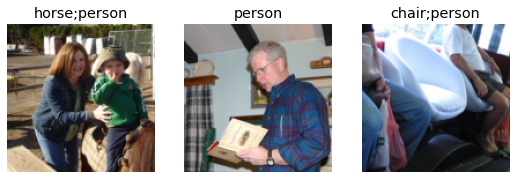

In [40]:
#Displaying the data
dls.show_batch(nrows=1, ncols=3)

While constructing DataBlock if we made some mistake , we can use the summary method we used in the 
last chapter.It outputs where we went wrong while constructing the DataBlock.

Now that we have created our Dataloaders also so our data can be trained now.So now we can create the
learner through which we pass the model architecture,the DataLoaders object,the optimizer and the loss
function.

Previously we learnt about many loss function such as Cross Entropy,Negative Log Likelihood Loss.Also
by default fastai picks up the Loss function on the basis of type of data present.Here fastai picks up
the "__Binary Cross Entropy__" here.Let's see what is Binary-Cross-Entropy.

### Binary Cross-Entropy

We have already loaded the data into DataLoaders object.Next we create the Learner with the 
dataloaders object,the model,the optimizer and the loss function to use.In model we use fastai's 
resnet-18 model and we would be using a SGD optimizer.Let's discuss about the loss function we would 
be using.First we create the learner with dls and resnet18.

In [42]:
#creating a learner
learn = cnn_learner(dls, resnet18)#dataloaders,the model architecture.

We know that the learner is object inherited from nn.Module.And we can get the activations of the 
model by passing the independent variable through the parantheses in learn.model as a mini-batch.
We can check the shape of the activations also.

In [44]:
#Getting the dependent,independent variables in first batch of data
x,y = dls.train.one_batch()#Getting a batch of data
model=learn.model.cuda()#moving the model on GPU
activs = learn.model(x)#Making model #gives activations 
activs.shape#getting the shape of activations

torch.Size([64, 20])

The shape of the activs is 64 X 20.We have total 64 Images in a mini-batch and therefore we need to
calculate the probabilities of every image for each of the 20 categories.Let's see how the range of 
the activations look like.

In [45]:
#Activations for first image in the batch
activs[0]

tensor([ 1.3049,  1.2204,  0.7176, -1.8188, -1.6927, -0.3548,  0.1879, -1.9554, -2.1884,  1.1693, -0.6384,  1.1238, -2.6990,  2.1288,  1.6764, -2.1219,  3.8406,  1.1212, -0.1236,  1.0238],
       device='cuda:0', grad_fn=<SelectBackward>)

These activations are not scaled between 0 and 1 yet so we cannot call them probabilities.We can do
the same using "sigmoid" function.In the previous chapter we have seen how to create a loss function
using torch.where we also take the log and then mean.

In [46]:
#Defining loss function  for cross binary entropy same as MNIST loss
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

Since the target is a one hot encoded vector , "nll_loss" or "softmax" and therefore cross entropy 
cannot be used because in softmax requires the sum of the predictions to be 1.And it escalates the 
value to a larger one due to exp,but there may be multiple objects so we cannot restrict the sum of
predictions to be 1.Also "nll_loss" gives the value of one activation,a single one for one label.This
cannot be used as we have multiple labels.Therefore we use "__binary_cross_entropy__" function which 
works like "mnist_loss" and also takes log.Every activation is compared to each target and there are
multiple columns for multiple labels.

This is one of the features of PyTorch which allows us to do element wise operations.Things like 
broadcasting thus allow executing operations for single item or a batch of items with no difference in
codes.

PyTorch provides the F.binary_cross_entropy function or module class equivalent to nn.BCELoss gives
cross-entropy on one hot encoded target,but doesn't have sigmoid.Another module class nn.BCEWithLogits
Loss does sigmoid along with cross entropy.
For single label classification the function used would be nn.NLLoss and nn.CrossEntropyLoss without
softmax function.

Since we have a one hot encoded vector as target,nn.BCEwithLogitsLoss function is used.Let's see how 
it works.


In [71]:
loss_func = nn.BCEWithLogitsLoss()#create an object for the BCE loss
loss = loss_func(activs, y)#Pass the targets and the predictions through the loss function 
loss#returns a single value for the loss 

tensor(1.1208, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

We do not always pass the loss function while creating the learner as fastai chooses it by default
according the type of data and input,output expected.When fastai sees the multilabelled images in 
DataLoaders,it chooses nn.BCEWithLegitLoss.

One more change which we introduce while training in this chapter is the metrics we use here.Since
many chapters we are using the accuracy function,but we cannot use it here as this is a multiclass 
problem.Accuracy is calculated for inputs and targets and the class predicted is the one with the 
highest activation.But here there are more than one predictions for a single image so after the 
activations are rescaled between 0 and 1 by applying sigmoid,they are kept or discarded by comparing 
to a threshold.Every value above the threshold is kept and considered as the labels for that image
and value less than the threshold is discarded and is treated as zero while converting into the 
one hot encoded vector.The definition for the function would be like:
    ```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

accuracy_multi function if passed directly a metric uses a default value of 0.5 as threshold.However
different default value can also be passed using partial functions in python.In this we actually 
combine a function with some arguments(threshold) in this case creating altogether a modified function
.Let's see how do we create a partial function with an extra argument.

In [47]:
 #The use of partial functions 
#adds hello by default to the name
def say_hello(name, say_what="Hello"): #say_hello function,say_what is the default argument if the 
    #value is not passed separately,if passed uses that value
    return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

The above function is a normal function definition containing a default argument called "say_what".If 
only one argument is passed through the function,it uses default value for the other argument.Else if
a value is passed for the other argument as well,it uses that.This can be restructured in small code
using the partial function concept.To create a partial function using say_hello,we pass the it 
through the partial keyword as an argument and the next argument is the default argument which will 
be passed through say_hello.Now whenever we call the function with a single argument the default will 
be added.

In [48]:
#Creating a partial function of say_hello
f = partial(say_hello, say_what="Bonjour")#say_what is the default argument
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

So we can also pass accuracy_multi function as a partial function with thresh as the default argument.
We can now create the learner by passing dataloaders,the model architecture and the metrics is the 
partial accuracy_multi function.We set the threshold as 0.2 for now.While fine tuning the model for 
three epochs,the base learning rate is 3 X 10^-3.It freezes layers after 4 epochs and then trains 
for 3 epochs again

In [49]:
#passing a partial function for calculating accuracy so as to change threshold
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)#Training the initial layers for 4 epochs randomly 
#and then freezing and training again for 3 epochs
#95% accuracy

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944139,0.705610,0.232530,01:20
1,0.822065,0.562211,0.299542,01:10
2,0.601005,0.199450,0.828725,01:11
3,0.359300,0.123258,0.941753,01:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132208,0.115503,0.945538,01:18
1,0.115979,0.109108,0.947530,01:17
2,0.096787,0.104317,0.952869,01:17


The accuracy is 95%.But it will vary with the threshold everytime.If the threshold is very low,then 
we won't be getting correctly labelled images in output much.We can change the threshold value and 
then using validate method get the validation loss and the metrics.

In [50]:
#Changing the threshold to 0.1 and getting the validation loss and the metric value
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10431691259145737,0.9310159683227539]

Next we use a very high threshold and then note the change in the loss and the accuracy here.It will 
be selecting only those classes where model is very confident.

In [51]:
#changing the threshold value to 0.99
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10431691259145737,0.9424301981925964]

There is no definite method for selecting best threshold.We have to try some and then select out of 
them.First let us get all the predictions and targets in one go using the get_preds() method.

In [52]:
#get_preds for predictions and targets
preds,targs = learn.get_preds()

Next we directly call the accuracy_multi function on the predictions and targets.We also pass the 
threshold value of 0.9 here.Also get_preds applied sigmoid on the predictions by default so we need 
not apply it again so we pass "sigmoid=False" through accuracy_multi.

In [53]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9561)

Applying function directly gives us a single value for accuracy.This can be used to find the best 
threshold value for a range of thresholds between 0 and 1.For doing so we first define a range of 
threshold values starting from 0.05 and ending at 0.95.Next using a Python list comprehension we 
apply the accuracy_multi function for each threshold value and get the accuracy.We get the list of 
accuracies in this way and then we plot them together to select the best among them.

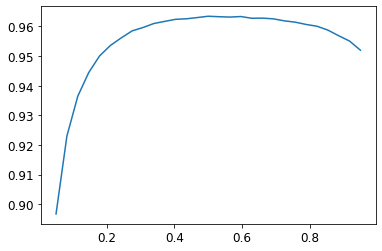

In [54]:
#Finding threshold for the acccuracy
xs = torch.linspace(0.05,0.95,29)#range of the thresholds
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]#list of the accuracies in 
#list comprehension
plt.plot(xs,accs);#plotting them together
#Optimal threshold seems to be 0.5

Here we are trying to find the threshold value using validation set.Now threshold is a hyperparameter
which has to be decided earlier before training the model.There may be some conflicts here that this
may lead to overfitting as we are trying to fit the results according to our data.As we change 
threshold the results also vary.We should therefore be careful about if while trying many 
hyperparameter values,we are not overfitting the model.

Let's train the model now by creating a learner by passing dataloaders,the model architecture,the 
metrics which is accuracy_multi with a threshold of 0.5 and then fine_tune the model.

In [30]:
#Training the model using a thereshold of 0.5
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)  #Fine tuning the model

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.948394,0.705602,0.617908,00:33
1,0.825871,0.554700,0.741892,00:33
2,0.601361,0.202785,0.950677,00:34
3,0.359412,0.127758,0.956474,00:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136151,0.117816,0.959841,00:36
1,0.119077,0.106228,0.963526,00:36
2,0.097577,0.103901,0.963506,00:36


Finally we have an accuracy of about 96.3%.Previously in the start of this chapter we mentioned that 
we would be discussing about multilabel classification and regression.We are done with multi-label
classification so let's learn about Regression now...

## Regression

We know deep learning is applied in major domains like computer vision,NLP and so on..Fastai also 
classifies its modules like this.Other libraries also do the same.

But if we go much deeper a model is differentiated mainly using its dependent,indepndent variables and 
the loss function.So types of models cannot be just based on domain basis.Sometimes we have image as 
independent variable and dependent variable as text (captioning images) or the opposite(caption from 
images).We can also have a combination of all where we have independent variable as text,images and tabular data and the dependent variables are "purchases".

To develop different models,we should try to understand DataBlock API well.Image regression is one of
the problems.Independent variable is Image here and the dependent variable is continuous number.It is
considered as a separate domain but we would train it as an another CNN problem.

In the further section we would be discussing about key point model.Key point model uses a specific 
position in image.In the next model we will be predicting the center of a person's face in the image.
So we would be calculating two numbers,one for row no and one for column no.

Let's start with the model by first downloading the data..

### Assemble the Data

As usual we download and extract the dataset "Biwi Kinet Head Pose" using untar_data and set the path.

In [55]:
#Predicting the position of heads in every image
path = untar_data(URLs.BIWI_HEAD_POSE)

In [56]:
#hide
#setting the path
Path.BASE_PATH = path

Next we explore the contents of the folder using the ls method.

In [72]:
#exploring the contents of the folder
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories inside the dataset(corresponding to each) and a .obj file for each.Let us 
explore the contents of each directory.

In [73]:
#exploring the contents of the directory
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Inside this directory there are different frames which have a text file and an image with them.We
get the image files using the get_image_files by passing the path.Next we define a function "img2pose"
which returns the corresponding position file(text) for the image. 

In [74]:
#Get image files and function for getting the position file for the passed image.
img_files = get_image_files(path)
def img2pose(x): 
    return Path(f'{str(x)[:-7]}pose.txt')#returns the path to corresponding position file.
img2pose(img_files[0])

Path('01/frame_00003_pose.txt')

Next we display the first image.

In [75]:
#displaying the image
im = PILImage.create(img_files[0])#Creating a PIL Image 
im.shape#shape of the image

(480, 640)

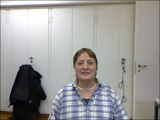

In [76]:
#downsizing the image
im.to_thumb(160)

The biwi dataset website has mentioned a formular for calculating the  position of the head in the 
image.The text file associated with each image has some coordinates which are used to calculate the 
center of the head.Thus next we define a function get_ctr which returns a tensor containing the 
2-D coordinates of the center of the head in the passed image.np.genfromtext is used to extract the 
numbers from the text file.

In [77]:
#Function for calculating centre from the images
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):#pass the image file
    ctr = np.genfromtxt(img2pose(f), skip_header=3)#get the numbers from the text file
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]#formula for calculating the center of head in each 
    #image(row)
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]#(column coordinates)
    return tensor([c1,c2])#return a tensor containing both coordinates

Next we pass the first image file through the get_ctr function to get the coordinates.

In [78]:
#passing the image file through the get_ctr function
get_ctr(img_files[0])

tensor([350.4915, 262.9643])

Now we create DataBlock for this data.We would be passing this get_ctr function through get_y in 
Datablock as it is the label for each image.For blocks we pass ImageBlock as input and PointBlock as 
output and get_image_files to get the items.We cannot use random splitter here as there are folders
containing images of multiple persons with each folder containing images of one person.Therefore in
splitter we pass a function which returns images for just one person.
A Point Block is passed as the output block so that fastai does augmentation to the coordinates as it
knows that labels are coordinates through Point Block.

We also apply augmentation transforms which resizes the images to half the size and apply batch 
normalization.

In [79]:
#Creating datablock for the data
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),#Image block for input and Point Block for output
    get_items=get_image_files,#get the image files
    get_y=get_ctr,#get_ctr function for center coordinates
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),#returns image files in a particular folder
    batch_tfms=[*aug_transforms(size=(240,320)),#resizing the image 
                Normalize.from_stats(*imagenet_stats)])#batch normalization

Next we create dataloaders object using the dataloaders method by passing path.We use "show_batch" 
method to display the images before training the data once.

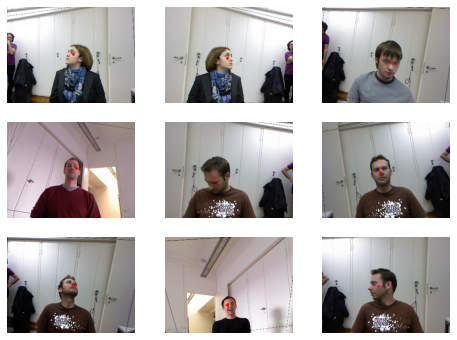

In [80]:
#Creating dataloaders for the data
dls = biwi.dataloaders(path,num_workers=0)
dls.show_batch(max_n=9, figsize=(8,6))#displaying images
#the red dots point to the center of the image

Let's look at the shape of the dependent and independent variables in a mini-batch.

In [81]:
#displaying the shape of a mini batch
xb,yb = dls.one_batch()
xb.shape,yb.shape #shape of the independent and dependent variables in the batch 
#3 in xb-no of channels(rgb)

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Let us see the first row in the dependent variable.

In [82]:
#getting the first element in yb
yb[0]

tensor([[-0.2910, -0.0887]], device='cuda:0')

We did not use any specific Image Regression module here instead we followed the normal procedure of
creating datablock API and then dataloaders.Only difference was the labelling function and the type of
input and output 

Now let's create the Learner and train the model

### Training a Model

We would be using cnn_learner to train our model.Since this is a regression problem so we also have to
pass y_range as the argument for the target range through the learner.Since the coordinates are 
standardised between -1 and 1 therefore we keep the range of -1 to 1.

In [83]:
#Creating a learner
learn = cnn_learner(dls, resnet18, y_range=(-1,1))
#y_range-range of data in dependent variable for regression

y_range is defined in fastai using the below sigmoid_range function.here lo and hi are -1 and 1 
respectively.The function rescales the values in the range(lo,hi).Let's see the plot...

In [84]:
#function for scaling a value in particulr range(lo,hi)
def sigmoid_range(x, lo, hi): 
    return torch.sigmoid(x) * (hi-lo) + lo

To plot the function between -1 and 1 we pass the partial function for sigmoid_range and the value of
lo and hi as -1 and 1 respectively.

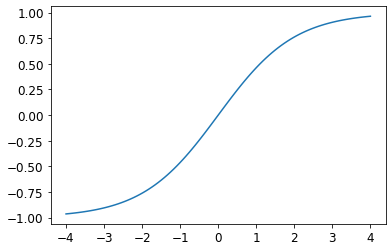

In [85]:
#plotting sigmoid_range function
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

We has mentioned earlier also that we do not have to pass the loss function always as fastai selects 
it by default.Let's see which one fastai has chosen

In [86]:
#Specifying loss function
dls.loss_func

FlattenedLoss of MSELoss()

The learner uses flattened mean squared error as the loss function because when coordinates are the 
output so most of the time predictions would be very close so MSE is used for such problems only to
predict closer things.We can pass a different loss function also through the learner in loss_func 
argument.

We did not pass any metrics for the learner.That is because MSE is also the metrics for the problem.

Next we use learning rate finder to get the optimal learning rate

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.5848931980144698e-06)

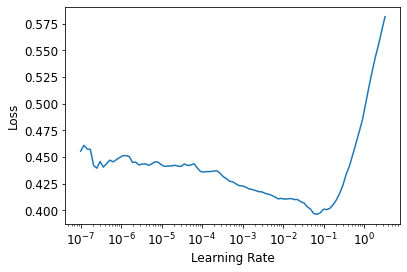

In [70]:
#Finding the optimal learning rate
learn.lr_find()
#lr=0.01

From the plot above 10^-2 is an optimal learning rate so let's try training a model for 3 epochs with
the same learning rate using fine_tune method.

In [57]:
#training the model for 3 epochs and 0.01 learning rate
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.048337,0.015333,02:43


epoch,train_loss,valid_loss,time
0,0.008741,0.001229,03:20
1,0.002900,0.000134,03:22
2,0.001504,0.000116,03:21


Currently we are getting a loss of 0.01% error.Let's take the square root of it as this is the 
squared error.So the square root counts to 0.01 hardly.

In [58]:
math.sqrt(0.0001)

0.01

This model is very accurate.Let's look at the results with the show_results method.It returns both
targets and predictions.So left side images are the targets and the right side images contain the red 
dot at the position predicted using the model.

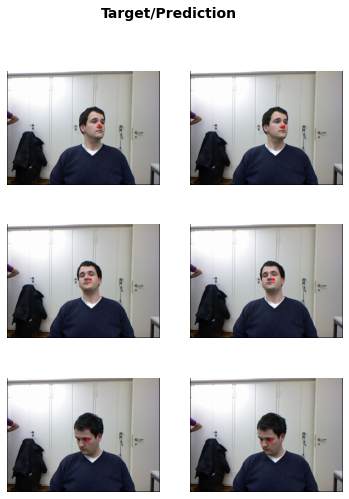

In [59]:
#displaying targets and predictions together
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

It is very nice that we actually trained a "key-point" model withut the use of any special module.
We created DataBlock APIs and trained the model using Transfer Learning.While using transfer learning
the pretrained model is for Image Classification but we also use it for differen tasks such as Image 
regression.

## Conclusion

Fastai and PyTorch use different outputs and different inputs.We have built many different models for
problems such as "single label classification","multilabel classification and regression.The loss 
function changes with the type of data and it is important to check once before training the model.

fastai by default decides the metrics and the loss function to be used for training on the basis of
the data.But if Pure PyTorch is used to built DataLoaders we need to specify the  loss function.

Some of the loss functions used are as follows:-

1.nn.CrossEntropyLoss for single label classification

2.nn.BCEWithLogits loss for multilabelled classification

3.nn.MSELoss for regression problems.

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your inputs images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.

# Answers:-

Ans-1 The problem with the earlier bear classifier was that if any image did not have any bear still 
it will predict something.However if the model is trained using a multilabel classifier then it would
have ability to predict "no bear at all".

Ans-2 The dependent variable is encoded as a one hot encoded vector consisting of zeros and ones 
representing categories/classes in the order present in vocab.The zeros represent the class not 
present and one represents class being present.

Ans-3 The rows and columns of a dataframe can be accessed using iloc property or without iloc also.
df[a,b] a is row and b is column.

Ans-4 df["col1"]

Ans-5 Dataset and DataLoader are the two main classes provided by PyTorch for storing and accessing
training set and validation set.Dataset returns tuple containing pairs of dependent and independent
variables.DataLoader iterates the data into mini-batches where every mini-batch consists of tuple of
dependent and independent variables.

Ans-6 A Datasets object contains a training and a validation dataset which in turn contain tuples of
dependent and independent variable pairs.

Ans-7 Dataloaders contain a training dataloader and a validation dataloader which contain the mini
batches for both training and validation.

Ans-8 lambda is used for anonymous functions.It can take any number of arguments but can have only one
expression.lambda a,b:a+b

Ans-9 Dependent and independent variables are passed through the DataBlock API through get_x and get_y
functions.We can create these functions like defining them like normal functions and then calling them
in get_x and get_y or using lambda keyword and defining them directly inside DataBlock API.Both 
methods produce the same result but lambda functions are used for quick iterations and not for
serialization.

Ans-10 Softmax requires the sum of all the predicted probabilities for all the classes to be one.But 
in case of multilabel classification,the image may contain multiple objects so sum of activations
cannot be 1.

Ans-11 nn.nll_loss is used when its single label classification and target is a single integer.It 
returns a single activation corresponding to a single label.

Ans-12 nn.BCELoss calculates cross entropy for one hot encoded target but without sigmoid whereas the 
nn.BCEWithLogitsloss does sigmoid and cross entropy in one function.

Ans-13 Accuracy compares the targets with the predictions and the predicted class is the one with 
highest activation.But in multilabel problem because one image would have more than one predictions 
and after applying sigmoid we decided a threshold to decide which class the Image belongs to and to
which not.

Ans-14 If on changing hyperparameter we get a smooth curve when it is plotted with metric then it is 
fine to tune the value using validation set.

Ans-15 def sigmoid_range(x,lo,hi):
         return(torch.sigmoid(x)*(hi-lo)+lo)
    
Ans-16 A regression problem is such that the dependent variable is a continuous numerical value and 
unique for every row.We use a mean squared error as loss function which is also used as a metric.The 
predictions are close to each other in regression so MSE helps in predicting values close to each 
other.

Ans-17 While building DataBlock API for biwi dataset we pass the output as PointBlock initially so as 
the fastai knows that the labels are coordinate predictions so when it does augmentation it does the 
same to coordinates also.